In [33]:
import torch
import math
from torch.utils import data
import matplotlib.pyplot as plt

import torch.nn.functional as F
from torch import nn
import numpy as np
from scipy.sparse import coo_matrix
import seaborn as sns


## Data Generation

In [34]:
def swiss_roll(data_size, shuffle=True, nf=2, noise_std=0, input_ch=None):

    data2d = torch.zeros(data_size, 2, 1)
    label = torch.ones(data_size, 1)
    label[math.floor(data_size / 2):, :] = 0

    r1 = torch.linspace(0, 1, math.ceil(data_size / 2))
    r2 = torch.linspace(0.2, 1.2, math.ceil(data_size / 2))
    theta = torch.linspace(0, 4 * math.pi - 4 * math.pi / math.ceil(data_size / 2), math.ceil(data_size / 2))
    data2d[0:math.ceil(data_size / 2), 0, 0] = r1 * torch.cos(theta)
    data2d[0:math.ceil(data_size / 2), 1, 0] = r1 * torch.sin(theta)
    data2d[math.floor(data_size / 2):, 0, 0] = r2 * torch.cos(theta)
    data2d[math.floor(data_size / 2):, 1, 0] = r2 * torch.sin(theta)
    if noise_std:
        for i in range(2):
            data2d[:, i, 0] = data2d[:, i, 0] + noise_std*torch.randn(data_size)

    if shuffle:
        data2d, label = _data_shuffle(data2d, label)
    
    if nf != 2:
        data2d = _data_extension(data2d, nf, input_ch)
    
    domain = [-1.2, 1.2, -1.2, 1.2]
    return data2d, label, domain

In [35]:
data_size = 8000
train_data_size = 4000
test_data_size = data_size - train_data_size
nf = 6
data_gen = swiss_roll

In [36]:
def _data_shuffle(data2d, label):
    data_size = data2d.shape[0]
    randindex = torch.randperm(data_size)
    data2d = data2d[randindex, :, :]
    label = label[randindex, :]
    return data2d, label
def _data_extension(data2d, nf, input_ch=None):
    if nf < 2:
        print("Dimension not valid")
        return
    elif nf % 2 == 1:
        print("Using odd dimension nf")
    data_size = data2d.shape[0]
    if input_ch is not None:
        # input_ch is a list of two elements. The elements indicate where the data enters.
        idx_x = input_ch[0]
        idx_y = input_ch[1]
    else:
        idx_x = 0
        idx_y = nf-1
    data2d = torch.cat((torch.zeros(data_size, idx_x-0, 1),
                        data2d[:, 0:1, :],
                        torch.zeros(data_size, idx_y-idx_x-1, 1),
                        data2d[:, 1:2, :],
                        torch.zeros(data_size, nf-1-idx_y, 1)), 1)
    return data2d

In [37]:
data2d, labels, domain = data_gen(data_size,nf=nf)

In [38]:
class Dataset(data.Dataset):

    def __len__(self):
        return len(self.list_ids)

    def __init__(self, list_ids, data_in, labels):
        self.list_ids = list_ids
        self.data = data_in
        self.labels = labels

    def __getitem__(self, index):

        idx = self.list_ids[index]

        x = self.data[idx, :, :]
        y = self.labels[idx, :]

        return x, y

partition = {'train': range(0, data_size, 2),
             'test': range(1, data_size, 2)}
training_set = Dataset(partition['train'], data2d, labels)


In [39]:
training_generator = data.DataLoader(training_set, batch_size=125, shuffle=True)

## Integrator

In [40]:
t_end = 0.5
n_layers = 8
h = t_end / n_layers

In [41]:
# # Select training parameters
alpha = 5e-4
alphac = 1e-4
learning_rate = 1e-1 #0.5e-1
max_iteration = 150
max_in_iteration = 10


# define network structure and optimizer
batch_size = 125
training_set = Dataset(partition['train'], data2d, labels)
training_generator = data.DataLoader(training_set, batch_size=batch_size, shuffle=True)

In [42]:
class H1(nn.Module):
    # Hamiltonian neural network, as presented in [1,2].
    # H_1-DNN and H_2-DNN
    # General ODE: \dot{y} = J(y,t) K(t) \tanh( K^T(t) y(t) + b(t) )
    # Constraints:
    #   J(y,t) = J_1 = [ 0 I ; -I 0 ]  or  J(y,t) = J_2 = [ 0 1 .. 1 ; -1 0 .. 1 ; .. ; -1 -1 .. 0 ].
    # Discretization method: Forward Euler
    def __init__(self, n_layers, t_end, nf, random=True, select_j='J1'):
        super().__init__()

        self.n_layers = n_layers  # nt: number of layers
        self.h = t_end / self.n_layers  #interval
        self.act = nn.Tanh()    # activation function
        self.nf = nf            # number of features

        if random:
            K = torch.randn(self.nf, self.nf, self.n_layers)
            b = torch.randn(self.nf, 1, self.n_layers)
        else:
            K = torch.ones(self.nf, self.nf, self.n_layers)
            b = torch.zeros(self.nf, 1, self.n_layers)

        self.K = nn.Parameter(K, True)
        self.b = nn.Parameter(b, True)

        if select_j == 'J1':
            j_identity = torch.eye(self.nf//2)
            j_zeros = torch.zeros(self.nf//2, self.nf//2)
            self.J = torch.cat((torch.cat((j_zeros, j_identity), 0), torch.cat((- j_identity, j_zeros), 0)), 1)
        else:
            j_aux = np.hstack((np.zeros(1), np.ones(self.nf-1)))
            J = j_aux
            for j in range(self.nf-1):
                j_aux = np.hstack((-1 * np.ones(1), j_aux[:-1]))
                J = np.vstack((J, j_aux))
            self.J = torch.tensor(J, dtype=torch.float32)

    def getK(self):
        return self.K

    def getb(self):
        return self.b

    def getJ(self):
        return self.J

    def forward(self, Y0, ini=0, end=None):

        dim = len(Y0.shape)
        Y = Y0.transpose(1, dim-1)

        if end is None:
            end = self.n_layers
        
        for j in range(ini, end):
            Y = Y + self.h * F.linear(self.act(F.linear(
                Y, self.K[:, :, j].transpose(0, 1), self.b[:, 0, j])), torch.matmul(self.J, self.K[:, :, j]))
            
        NNoutput = Y.transpose(1, dim-1)

        return NNoutput

In [43]:
class Classification(nn.Module):
    def __init__(self, nf=2, nout=1):
        super().__init__()
        self.nout = nout
        self.W = nn.Parameter(torch.zeros(self.nout, 1), True)
        self.mu = nn.Parameter(torch.zeros(1, self.nout), True)

    def forward(self, Y0):
        # Y = Y0.transpose(1, 2)
        Y = Y0.unsqueeze(1).unsqueeze(2)
        NNoutput = F.linear(Y, self.W, self.mu).squeeze(1)
        return NNoutput

In [44]:
def regularization(alpha, h, K, b):
    # Regularization function as introduced in [1]
    n_layers = K.shape[-1]
    loss = 0
    for j in range(n_layers - 1):
        loss = loss + alpha * h * (1 / 2 * torch.norm(K[:, :, j + 1] - K[:, :, j]) ** 2 +
                                   1 / 2 * torch.norm(b[:, :, j + 1] - b[:, :, j]) ** 2)
    return loss

## Training - Hamilton + Classification Layer

In [45]:
model = H1(n_layers, t_end, nf=nf, select_j='J1')

In [46]:
loss_func = nn.BCEWithLogitsLoss()
optimizer_k = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [47]:
def compute_H(y,K,b):
    n_layers = K.shape[-1]
    H = torch.sum(torch.log(torch.cosh(F.linear(
                y.squeeze(2), K[:, :, n_layers-1].transpose(0, 1), b[:, 0, n_layers-1]))),1)
    return H

In [48]:
for epoch in range(max_iteration):

    training_iterator = iter(training_generator)

    for i_k in range(int(data2d[partition['train']].size(0) / training_generator.batch_size)):

        local_samples, local_labels = next(training_iterator)
        
        model_c = Classification(nf=nf)
        optimizer_w = torch.optim.Adam(model_c.parameters(), lr=learning_rate)
        
        with torch.no_grad():
            YN = model(local_samples)
        
        optimizer_k.zero_grad()
        K = model.getK()
        b = model.getb()
        
        for i_w in range(max_in_iteration):  # Inner iteration
            optimizer_w.zero_grad()
            loss = loss_func(model_c(compute_H(YN,K,b)), local_labels)
            loss = loss + alphac * 0.5 * (torch.norm(model_c.W) ** 2 + torch.norm(model_c.mu) ** 2)
            loss.backward()
            optimizer_w.step()
        
        loss = loss_func(model_c(compute_H(model(local_samples),K,b)), local_labels)
        loss += regularization(alpha, h, K, b)
        loss.backward()
        li = list(optimizer_k.state)
        if not (len(li) == 0):
            for ii in range(2):
                optimizer_k.state[li[ii]]['step'] = epoch
        optimizer_k.step()
 

    if epoch % 10 == 0:
        model_c = Classification(nf=nf)
        optimizer_w = torch.optim.Adam(model_c.parameters(), lr=learning_rate)
        with torch.no_grad():
            YN = model(local_samples)
        
        for i_w in range(max_in_iteration):  # Inner iteration
            optimizer_w.zero_grad()
            loss = loss_func(model_c(compute_H(YN,K,b)), local_labels)
            loss = loss + alphac * 0.5 * (torch.norm(model_c.W) ** 2 + torch.norm(model_c.mu) ** 2)
            loss.backward()
            optimizer_w.step()
            acc = (torch.ge(model_c(compute_H(model(local_samples),K,b)), 0) == local_labels).sum().numpy() / batch_size
        print('\tTrain Epoch: {:2d} - Loss: {:.6f} - Accuracy: {:.2f}%'.format(epoch, loss, acc*100))

# Train classification layer with all the data

# Accuracy results

with torch.no_grad():
    train_acc = (torch.ge(model_c(compute_H(model(data2d[partition['train'], :, :]),K,b)), 0) == labels[partition['train'], :]
                 ).sum().numpy() / train_data_size
    test_acc = (torch.ge(model_c(compute_H(model(data2d[partition['test'], :, :]),K,b)), 0) == labels[partition['test'], :]
                ).sum().numpy() / test_data_size
    
print('\tTrain Accuracy: {:.2f}%'.format(train_acc*100))
print('\tTest Accuracy: {:.2f}%'.format(test_acc*100))

	Train Epoch:  0 - Loss: 0.613061 - Accuracy: 70.40%
	Train Epoch: 10 - Loss: 0.239849 - Accuracy: 98.40%
	Train Epoch: 20 - Loss: 0.233510 - Accuracy: 98.40%
	Train Epoch: 30 - Loss: 0.197419 - Accuracy: 100.00%
	Train Epoch: 40 - Loss: 0.187849 - Accuracy: 100.00%
	Train Epoch: 50 - Loss: 0.208303 - Accuracy: 100.00%
	Train Epoch: 60 - Loss: 0.192877 - Accuracy: 100.00%
	Train Epoch: 70 - Loss: 0.222267 - Accuracy: 99.20%
	Train Epoch: 80 - Loss: 0.231294 - Accuracy: 99.20%
	Train Epoch: 90 - Loss: 0.230211 - Accuracy: 100.00%
	Train Epoch: 100 - Loss: 0.233998 - Accuracy: 98.40%
	Train Epoch: 110 - Loss: 0.198910 - Accuracy: 99.20%
	Train Epoch: 120 - Loss: 0.211271 - Accuracy: 100.00%
	Train Epoch: 130 - Loss: 0.196738 - Accuracy: 100.00%
	Train Epoch: 140 - Loss: 0.212369 - Accuracy: 100.00%
	Train Accuracy: 99.62%
	Test Accuracy: 99.33%


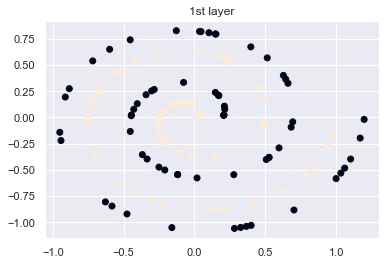

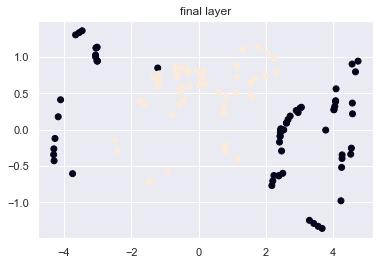

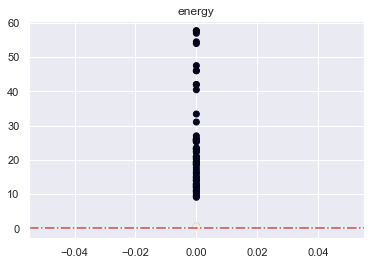

In [49]:
plt.scatter(local_samples.data.numpy()[:,0],local_samples.data.numpy()[:,nf-1],c=local_labels)
plt.title('1st layer')
plt.show()

plt.scatter(YN.data.numpy()[:,0],YN.data.numpy()[:,nf-1],c=local_labels)
plt.title('final layer')
plt.show()

plt.scatter(np.zeros(125),compute_H(YN,K,b).data.numpy(),c=local_labels)
plt.axhline(0, label='mean',linestyle='-.', color='r')
plt.title('energy')
plt.show()

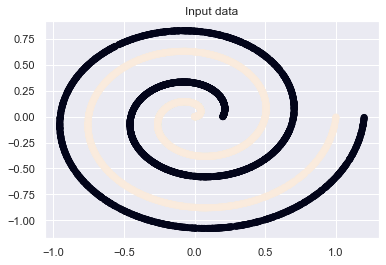

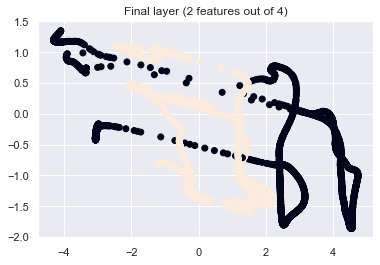

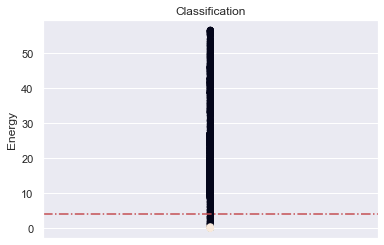

In [50]:
plt.scatter(data2d[partition['test'], :, :].data.numpy()[:,0],data2d[partition['test'], :, :].data.numpy()[:,nf-1],c=labels[partition['test'], :])
plt.title('Input data')
plt.show()

plt.scatter(model(data2d[partition['test'], :, :]).squeeze(2).data.numpy()[:,0],model(data2d[partition['test'], :, :]).squeeze(2).data.numpy()[:,1],c=labels[partition['test'], :])
# plt.plot([-4,6],[4,-4],color='r')
plt.title('Final layer (2 features out of 4)')
plt.show()

plt.scatter(np.zeros(test_data_size),compute_H(model(data2d[partition['test'], :, :]),K,b).data.numpy(),c=labels[partition['test'], :])
plt.axhline(4, label='mean',linestyle='-.', color='r')
plt.xticks([])
plt.ylabel("Energy")
plt.title('Classification')
plt.show()

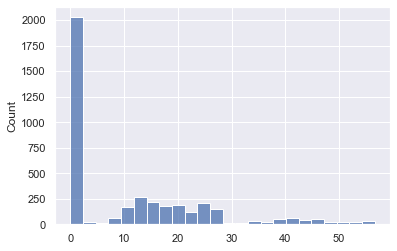

In [51]:
with torch.no_grad():
    H_test = compute_H(model(data2d[partition['test'], :, :]),K,b)
sns.histplot(H_test)
plt.show()

In [52]:
def viewContour2D_energy(domain, model,model_c, input_ch=None):
    '''
    Coloured regions in domain represent the prediction of the DNN given the Hamiltonian net (model) and the output
    layer (modelc).
    input_ch indicates the indexes where the input data is plugged
    For 2d datasets.
    '''
    N = 200
    xa = np.linspace(domain[0], domain[1], N)
    ya = np.linspace(domain[2], domain[3], N)
    xv, yv = np.meshgrid(xa, ya)
    y = np.stack([xv.flatten(), yv.flatten()])
    y = np.expand_dims(y.T, axis=2)
    data2d = torch.from_numpy(y).float()
    nf = model.nf
    if nf != 2:
        data2d = _data_extension(data2d, nf, input_ch)
        # dataSize = data2d.shape[0]
        # if input_ch is not None:
        #     # input_ch is a list of two elements. The elements indicate where the data enters.
        #     idx_x = input_ch[0]
        #     idx_y = input_ch[1]
        # else:
        #     idx_x = 0
        #     idx_y = nf-1
        # data2d = torch.cat((torch.zeros(dataSize, idx_x-0, 1),
        #                   data2d[:, idx_x:idx_x+1, :],
        #                   torch.zeros(dataSize, idx_y-idx_x-1, 1),
        #                   data2d[:, idx_y:idx_y+1, :],
        #                   torch.zeros(dataSize, nf-1-idx_y, 1)), 1)
    
    with torch.no_grad():
        labels = torch.ge(model_c(compute_H(model(data2d),model.getK(),model.getb())).unsqueeze(1), 0).int()
    plt.contourf(xa, ya, labels.view([N, N]), levels=[-0.5, 0.5, 1.5], colors=['#EAB5A0', '#99C4E2'])

In [53]:
def viewTestData(partition, data2d, labels, input_ch=None):
    if input_ch is not None:
        # input_ch is a list of two elements. The elements indicate where the data enters.
        idx_x = input_ch[0]
        idx_y = input_ch[1]
    else:
        nf = data2d.shape[1]
        idx_x = 0
        idx_y = nf-1
    # Plot test data for 2d datasets.
    testDataSize = len(partition['test'])
    mask0 = (labels[partition['test'], 0] == 0).view(testDataSize)
    plt.plot(data2d[partition['test'], idx_x, :].view(testDataSize).masked_select(mask0),
             data2d[partition['test'], idx_y, :].view(testDataSize).masked_select(mask0), 'r+',
             markersize=2)

    # mask1 = (labels[partition['test'], 0] == 1).view(testDataSize)
    # plt.plot(data2d[partition['test'], idx_x, :].view(testDataSize).masked_select(mask1),
    #          data2d[partition['test'], idx_y, :].view(testDataSize).masked_select(mask1), 'b+',
    #          markersize=2)

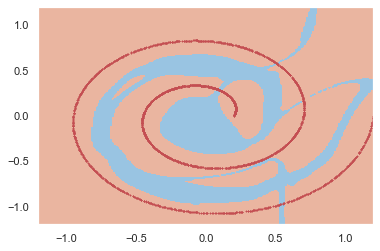

In [54]:
viewContour2D_energy(domain,model,model_c)
viewTestData(partition, data2d, labels)

In [55]:
data2d[partition['test'], :,:].shape

torch.Size([4000, 6, 1])

In [56]:
data2d_0 = []
data2d_1 = []
for i in range(test_data_size):
    if labels[partition['test'], :][i]==0:
        data2d_0.append(data2d[partition['test'], :, :][i])
    else:
        data2d_1.append(data2d[partition['test'], :, :][i])

In [57]:
data2d_0_0 = torch.cat(data2d_0, dim=1).T.unsqueeze(2)
data2d_1_1 = torch.cat(data2d_1, dim=1).T.unsqueeze(2)
data2d_0_0.shape

torch.Size([2005, 6, 1])

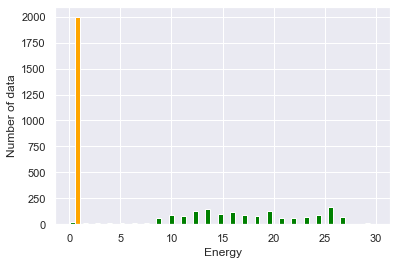

In [58]:
plt.hist([compute_H(model(data2d_0_0),K,b).data.numpy(),compute_H(model(data2d_1_1),K,b).data.numpy()], bins=25, range=(0,30), align=('mid'), color=['green', 'orange'], label=['Actual H band', 'Actual IRAC2 band']);
plt.xlabel("Energy")
plt.ylabel("Number of data")
plt.show();

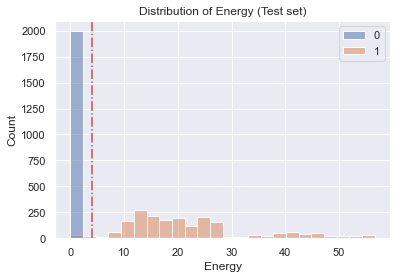

In [59]:
sns.histplot(data=[compute_H(model(data2d_1_1),K,b).data.numpy(),compute_H(model(data2d_0_0),K,b).data.numpy()])
plt.axvline(4, label='mean',linestyle='-.', color='r')
plt.xlabel('Energy')
plt.title('Distribution of Energy (Test set)');

In [60]:
sns.reset_orig()

In [61]:
sns.set()

In [62]:
mu = model_c(torch.Tensor([0]))
W = model_c(torch.Tensor([1]))-model_c(torch.Tensor([0]))
th = -mu/W

In [63]:
th

tensor([[1.4504]], grad_fn=<DivBackward0>)

In [64]:
b = model.getb()